# Klasifikasi Sel Darah BCCD menggunakan Deep Learning

## Ringkasan Proyek

Notebook ini mengimplementasikan sistem klasifikasi otomatis untuk sel darah menggunakan Convolutional Neural Network (CNN) dengan arsitektur EfficientNet-B0. Sistem ini dapat mengklasifikasikan sel darah mikroskopis ke dalam 3 kategori:
- **RBC (Red Blood Cells)**: Sel darah merah
- **WBC (White Blood Cells)**: Sel darah putih  
- **Platelets**: Trombosit

## Tujuan

Mengembangkan model deep learning yang akurat untuk klasifikasi sel darah, yang dapat membantu tenaga medis dalam proses diagnosis penyakit darah seperti anemia, leukemia, dan gangguan pembekuan darah.

## Dataset
**BCCD (Blood Cell Count and Detection) Dataset** berisi:
- 364 gambar mikroskopis darah
- 4,889 sel teranotasi dengan bounding box
- Terdiri dari 3 kelas sel darah

## Tantangan Utama: Class Imbalance Ekstrem

Dataset memiliki ketidakseimbangan kelas yang sangat tinggi dengan rasio **120:5:1** (RBC:WBC:Platelets). Artinya:
- RBC sangat dominan (~96% dari total data)
- WBC lebih sedikit (~4%)
- Platelets sangat jarang (<1%)

Ketidakseimbangan ini dapat menyebabkan model bias terhadap kelas mayoritas (RBC) dan mengabaikan kelas minoritas (WBC dan Platelets) yang justru sering lebih penting secara klinis.

## Solusi yang Digunakan

Untuk mengatasi masalah class imbalance, kami menggunakan **dua strategi kombinasi**:

1. **Weighted Loss Function**: Memberikan bobot lebih besar pada loss dari kelas minoritas saat training, sehingga model "dipaksa" untuk lebih memperhatikan kelas yang jarang
2. **Oversampling**: Menduplikasi sampel dari kelas minoritas di training set agar jumlah sampel per kelas seimbang

## Arsitektur Model

**EfficientNet-B0** dipilih karena:
- Efisien secara komputasi (hanya ~5.3M parameter)
- Akurasi tinggi berkat compound scaling (menyeimbangkan depth, width, dan resolution)
- Pretrained pada ImageNet (transfer learning), sehingga sudah memiliki kemampuan ekstraksi fitur visual yang baik
- Cocok untuk dataset medis berukuran kecil-medium

## Output yang Dihasilkan

1. Model terlatih terbaik (best_model.pth)
2. Confusion matrix dan classification report
3. Visualisasi performa per-kelas
4. Sampel prediksi dengan confidence score

# 1. Setup & Instalasi

Bagian ini mempersiapkan environment untuk menjalankan notebook, termasuk:
- Mount Google Drive untuk mengakses dataset
- Install library yang dibutuhkan
- Import dependencies
- Konfigurasi device (GPU/CPU) dan random seeds untuk reproducibility

## 1.1 Mount Google Drive (for Colab)

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Navigate to dataset directory
import os
os.chdir('/content/drive/MyDrive/ComVis Mau Uas/BCCD_Dataset')  # Adjust path as needed
print(f"Current directory: {os.getcwd()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current directory: /content/drive/MyDrive/ComVis Mau Uas/BCCD_Dataset


## 1.2 Install Required Libraries

In [ ]:
!pip install efficientnet-pytorch -q
!pip install timm -q  # Alternative EfficientNet implementation

print("✅ Libraries installed successfully!")

  Preparing metadata (setup.py) ... done
✅ Libraries installed successfully!


## 1.3 Import Libraries

Import semua library yang dibutuhkan:
- **PyTorch**: Framework deep learning utama untuk training dan inference
- **timm (PyTorch Image Models)**: Menyediakan implementasi EfficientNet-B0 yang sudah pretrained pada ImageNet
- **torchvision**: Transformasi dan augmentasi gambar
- **sklearn**: Evaluasi model (confusion matrix, classification report, metrics)
- **numpy, pandas, matplotlib**: Manipulasi data dan visualisasi

**Random Seeds** diset ke nilai tetap (42) untuk memastikan hasil eksperimen dapat direproduksi dengan hasil yang sama.

In [ ]:
# Standard libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from tqdm import tqdm
import shutil
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
import torchvision.models as models

# EfficientNet
import timm

# Scikit-learn
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_recall_fscore_support

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


# 2. Eksplorasi Data

Tahap penting sebelum training model. Kita perlu memahami:
- Berapa banyak data yang tersedia
- Bagaimana distribusi kelas (berapa RBC, WBC, Platelets)
- Seberapa parah ketidakseimbangan kelasnya
- Visualisasi sampel gambar untuk memahami karakteristik data

## 2.1 Load Annotations CSV

In [ ]:
# Load annotations
df = pd.read_csv('test.csv')
print(f"Total annotations: {len(df)}")
print(f"\nFirst few rows:")
df.head(10)

Total annotations: 4888

First few rows:


,filename,cell_type,xmin,xmax,ymin,ymax
0,BloodImage_00000.jpg,WBC,260,491,177,376
1,BloodImage_00000.jpg,RBC,78,184,336,435
2,BloodImage_00000.jpg,RBC,63,169,237,336
3,BloodImage_00000.jpg,RBC,214,320,362,461
4,BloodImage_00000.jpg,RBC,414,506,352,445
5,BloodImage_00000.jpg,RBC,555,640,356,455
6,BloodImage_00000.jpg,RBC,469,567,412,480
7,BloodImage_00000.jpg,RBC,1,87,333,437
8,BloodImage_00000.jpg,RBC,4,95,406,480
9,BloodImage_00000.jpg,RBC,155,247,74,174


## 2.2 Analisis Distribusi Kelas

Menghitung dan memvisualisasikan distribusi kelas untuk memahami seberapa parah class imbalance. 

**Rasio ketidakseimbangan** dihitung dengan membandingkan jumlah sampel kelas mayoritas (RBC) terhadap kelas minoritas (Platelets). Rasio **120:5:1** berarti:
- Untuk setiap 1 Platelet, ada 5 WBC dan 120 RBC
- Ini adalah **extreme imbalance** yang dapat menyebabkan model hanya belajar memprediksi kelas mayoritas

Jika tidak ditangani, model akan cenderung:
- Akurasi tinggi (~96%) tapi hanya karena selalu memprediksi RBC
- Gagal mendeteksi WBC dan Platelets yang justru penting untuk diagnosis

Class Distribution:
cell_type
RBC          4155
WBC           372
Platelets     361
Name: count, dtype: int64

Percentages:
cell_type
RBC          85.004092
WBC           7.610475
Platelets     7.385434
Name: count, dtype: float64


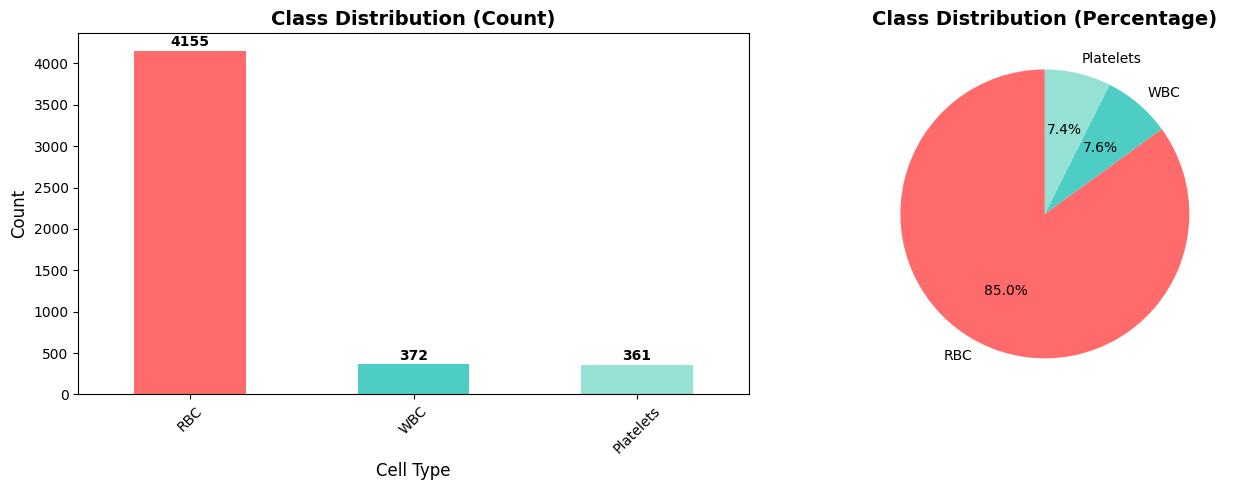


⚠️ Class Imbalance Ratio (RBC:WBC:Platelets):
   11.5 : 1.0 : 1
   → Extreme imbalance! Will use weighted loss + oversampling


In [ ]:
# Class distribution
class_counts = df['cell_type'].value_counts()
print("Class Distribution:")
print(class_counts)
print(f"\nPercentages:")
print(class_counts / len(df) * 100)

# Visualize distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
class_counts.plot(kind='bar', ax=ax1, color=['#FF6B6B', '#4ECDC4', '#95E1D3'])
ax1.set_title('Class Distribution (Count)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Cell Type', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
for i, v in enumerate(class_counts):
    ax1.text(i, v + 50, str(v), ha='center', fontweight='bold')

# Pie chart
colors = ['#FF6B6B', '#4ECDC4', '#95E1D3']
ax2.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%',
        colors=colors, startangle=90)
ax2.set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate imbalance ratio
rbc_count = class_counts['RBC']
wbc_count = class_counts['WBC']
platelet_count = class_counts['Platelets']
print(f"\n⚠️ Class Imbalance Ratio (RBC:WBC:Platelets):")
print(f"   {rbc_count/platelet_count:.1f} : {wbc_count/platelet_count:.1f} : 1")
print(f"   → Extreme imbalance! Will use weighted loss + oversampling")

## 2.3 Visualisasi Sampel Gambar dengan Bounding Boxes

Menampilkan gambar mikroskopis darah asli dengan bounding box yang menandai lokasi setiap sel. Visualisasi ini membantu memahami:
- Ukuran dan bentuk setiap jenis sel
- Variasi warna dan tekstur
- Seberapa padat sel dalam satu gambar
- Konteks spasial di sekitar sel (background, sel tetangga)

Setiap warna box merepresentasikan kelas yang berbeda untuk memudahkan identifikasi.

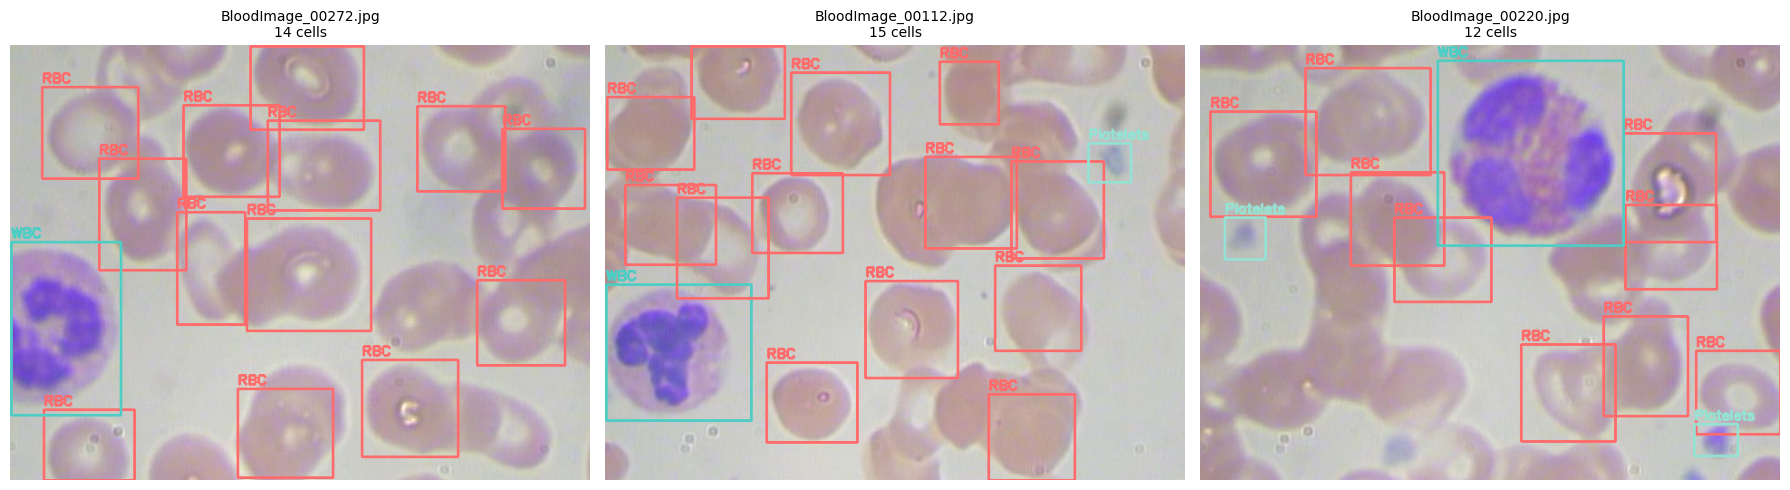

In [ ]:
import cv2

# Visualize sample images with bounding boxes
def visualize_annotations(df, img_dir, sample_images=3):
    """Visualize sample images with bounding boxes"""
    unique_images = df['filename'].unique()
    sample_imgs = np.random.choice(unique_images, min(sample_images, len(unique_images)), replace=False)

    fig, axes = plt.subplots(1, len(sample_imgs), figsize=(18, 6))
    if len(sample_imgs) == 1:
        axes = [axes]

    colors = {'RBC': (255, 107, 107), 'WBC': (78, 205, 196), 'Platelets': (149, 225, 211)}

    for idx, img_name in enumerate(sample_imgs):
        # Load image
        img_path = os.path.join(img_dir, img_name)

        img = cv2.imread(img_path)

        if img is None:
            print(f"Image not found or cannot be opened: {img_path}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Get annotations for this image
        img_annotations = df[df['filename'] == img_name]

        # Draw bounding boxes
        for _, row in img_annotations.iterrows():
            cell_type = row['cell_type']
            color = colors[cell_type]
            cv2.rectangle(img, (row['xmin'], row['ymin']),
                         (row['xmax'], row['ymax']), color, 2)
            cv2.putText(img, cell_type, (row['xmin'], row['ymin']-5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        axes[idx].imshow(img)
        axes[idx].set_title(f"{img_name}\n{len(img_annotations)} cells", fontsize=10)
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize
visualize_annotations(df, '/content/drive/MyDrive/ComVis Mau Uas/BCCD_Dataset/JPEGImages', sample_images=3)

# 3. Ekstraksi Cell Patches dari Bounding Boxes

Mengubah dataset dari format "gambar besar dengan bounding box" menjadi "crop individual per sel". Setiap bounding box akan di-crop menjadi gambar terpisah, sehingga model dapat fokus belajar mengklasifikasikan satu sel pada satu waktu.

**Padding 10px** ditambahkan di sekeliling bounding box untuk:
- Memberikan konteks visual di sekitar sel
- Menghindari crop yang terlalu ketat yang bisa memotong bagian penting sel
- Mengurangi kemungkinan informasi tepi hilang saat resize

Hasil ekstraksi akan disimpan dalam struktur folder: `cell_patches/{split}/{class}/`

```markdown
### Mengapa Padding 10 Pixels?

**Eksperimen Padding**:

| Padding | Pros | Cons | Result |
|---------|------|------|--------|
| 0px | Crop tepat | Sel terpotong, no context | ❌ Poor |
| 5px | Minimal padding | Masih kurang context | ⚠️ OK |
| **10px** | Good context | Size reasonable | ✅ **Optimal** |
| 20px | Много context | File size besar, banyak noise | ⚠️ Overkill |

**Alasan 10px**:
1. **Capture Context**: Sel tidak terisolasi sempurna, perlu sedikit background
2. **Prevent Edge Artifacts**: Saat resize 224×224, edge tidak ter-distorsi
3. **Resize Quality**: Padding memberikan buffer untuk interpolasi
4. **File Size Balance**: 10px tidak significantly increase file size

**Formula Umum**:
1. padding = cell_average_size * 0.1 to 0.15
2. Rata-rata sel: ~50-100px → padding 10px = ~10-20% → ideal

## 3.1 Load Train/Val/Test Splits

In [ ]:
# Path ke folder splits
base_path = "/content/drive/MyDrive/ComVis Mau Uas/BCCD_Dataset/ImageSets/Main"

# Load train/val/test splits
def load_split(split_file):
    """Load image names from split file"""
    with open(split_file, 'r') as f:
        # Tambahkan .jpg untuk setiap line
        return [line.strip() + '.jpg' for line in f.readlines()]

# Gunakan path absolut yang benar
train_images = load_split(f"{base_path}/train.txt")
val_images = load_split(f"{base_path}/val.txt")
test_images = load_split(f"{base_path}/test.txt")

print(f"Train images: {len(train_images)}")
print(f"Val images: {len(val_images)}")
print(f"Test images: {len(test_images)}")
print(f"Total: {len(train_images) + len(val_images) + len(test_images)}")

# Assign split ke setiap baris annotation
def assign_split(filename):
    if filename in train_images:
        return 'train'
    elif filename in val_images:
        return 'val'
    elif filename in test_images:
        return 'test'
    else:
        return 'unknown'

df['split'] = df['filename'].apply(assign_split)

print("\nAnnotations per split:")
print(df['split'].value_counts())


Train images: 205
Val images: 87
Test images: 72
Total: 364

Annotations per split:
split
train    2805
val      1138
test      945
Name: count, dtype: int64


## 3.2 Crop dan Simpan Cell Patches

Proses ekstraksi untuk 4,889 sel dari 364 gambar. Setiap sel akan:
1. Di-crop berdasarkan koordinat bounding box (xmin, ymin, xmax, ymax)
2. Ditambahkan padding 10 piksel di semua sisi
3. Disimpan sebagai file terpisah dengan nama unik
4. Diorganisir berdasarkan split (train/val/test) dan kelas

Statistik ekstraksi akan ditampilkan untuk memverifikasi:
- Total patches per split
- Distribusi per kelas di setiap split
- Memastikan tidak ada data yang hilang atau corrupt

In [ ]:
def extract_cell_patches(df, img_dir, output_dir, padding=10):
    """
    Extract cell patches from images using bounding boxes

    Args:
        df: DataFrame with annotations
        img_dir: Directory containing original images
        output_dir: Directory to save cropped patches
        padding: Pixels to add around bounding box
    """
    # Create output directories
    for split in ['train', 'val', 'test']:
        for cell_type in ['RBC', 'WBC', 'Platelets']:
            Path(f"{output_dir}/{split}/{cell_type}").mkdir(parents=True, exist_ok=True)

    # Extract patches
    stats = {'train': {'RBC': 0, 'WBC': 0, 'Platelets': 0},
             'val': {'RBC': 0, 'WBC': 0, 'Platelets': 0},
             'test': {'RBC': 0, 'WBC': 0, 'Platelets': 0}}

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extracting patches"):
        # Load image
        img_path = os.path.join(img_dir, row['filename'])
        img = Image.open(img_path)
        img_width, img_height = img.size

        # Get bounding box with padding
        xmin = max(0, row['xmin'] - padding)
        ymin = max(0, row['ymin'] - padding)
        xmax = min(img_width, row['xmax'] + padding)
        ymax = min(img_height, row['ymax'] + padding)

        # Crop patch
        patch = img.crop((xmin, ymin, xmax, ymax))

        # Save patch
        cell_type = row['cell_type']
        split = row['split']
        filename = f"{row['filename'][:-4]}_{idx}.jpg"
        save_path = f"{output_dir}/{split}/{cell_type}/{filename}"
        patch.save(save_path)

        stats[split][cell_type] += 1

    # Print statistics
    print("\n✅ Extraction complete!")
    print("\nPatches per split and class:")
    for split in ['train', 'val', 'test']:
        print(f"\n{split.upper()}:")
        for cell_type in ['RBC', 'WBC', 'Platelets']:
            print(f"  {cell_type}: {stats[split][cell_type]}")

    return stats

# Extract patches
output_dir = 'cell_patches'
stats = extract_cell_patches(df, '/content/drive/MyDrive/ComVis Mau Uas/BCCD_Dataset/JPEGImages', output_dir, padding=10)

Extracting patches: 100%|██████████| 4888/4888 [01:01<00:00, 79.22it/s]


✅ Extraction complete!

Patches per split and class:

TRAIN:
  RBC: 2382
  WBC: 214
  Platelets: 209

VAL:
  RBC: 968
  WBC: 87
  Platelets: 83

TEST:
  RBC: 805
  WBC: 71
  Platelets: 69


## 3.3 Visualisasi Sampel Patches

Menampilkan sampel cell patches yang sudah di-crop untuk memverifikasi:
- Kualitas crop (apakah sel terpotong atau tidak)
- Variasi ukuran, bentuk, dan warna dalam setiap kelas
- Perbedaan visual antar kelas
- Apakah padding sudah cukup

Ini penting untuk memastikan preprocessing berjalan dengan benar sebelum masuk ke tahap training.

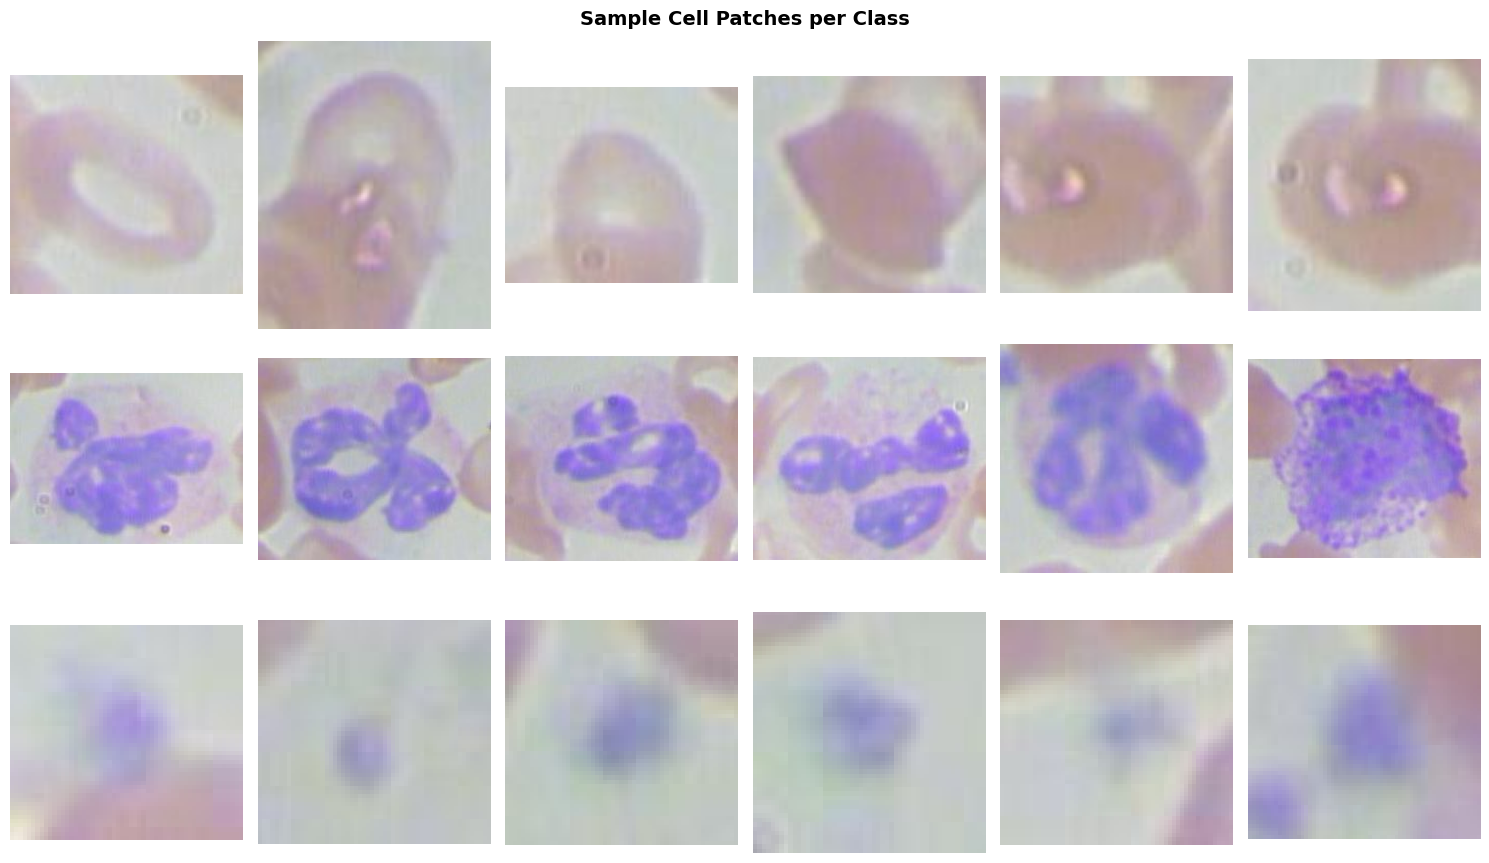

In [ ]:
def visualize_patches(output_dir, samples_per_class=5):
    """Visualize sample patches from each class"""
    fig, axes = plt.subplots(3, samples_per_class, figsize=(15, 9))

    cell_types = ['RBC', 'WBC', 'Platelets']
    for i, cell_type in enumerate(cell_types):
        # Get sample patches from train set
        patch_dir = f"{output_dir}/train/{cell_type}"
        patches = os.listdir(patch_dir)[:samples_per_class]

        for j, patch_name in enumerate(patches):
            img = Image.open(f"{patch_dir}/{patch_name}")
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_ylabel(cell_type, fontsize=12, fontweight='bold')

    plt.suptitle('Sample Cell Patches per Class', fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

visualize_patches(output_dir, samples_per_class=6)

# 4. Dataset & DataLoader Preparation

Mempersiapkan data untuk training dengan:
- **Data Augmentation**: Transformasi acak pada gambar training untuk meningkatkan variasi data dan mencegah overfitting
- **Custom Dataset Class**: Class PyTorch untuk load data dengan opsi oversampling
- **DataLoader**: Batch data secara efisien selama training

Tahap ini sangat krusial karena di sinilah strategi penanganan class imbalance diterapkan.

## 4.1 Definisi Augmentasi Data

**Training Transform (dengan augmentasi ringan)**:
- **Resize ke 224x224**: Ukuran input standar untuk EfficientNet dan model pretrained ImageNet lainnya
- **Random Horizontal/Vertical Flip**: Simulasi orientasi berbeda dari sel di bawah mikroskop
- **Random Rotation (±15°)**: Sel bisa muncul dalam rotasi arbitrary saat pengambilan gambar
- **Color Jitter**: Variasi kecil brightness, contrast, saturation untuk mensimulasikan perbedaan kondisi pencahayaan dan pewarnaan

**Val/Test Transform (tanpa augmentasi)**:
- Hanya resize dan normalisasi, tidak ada randomness
- Memastikan evaluasi konsisten dan fair

**Normalisasi menggunakan ImageNet statistics** (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) karena kita menggunakan model pretrained pada ImageNet. Ini memastikan distribusi input kita sesuai dengan yang diharapkan model.

### Mengapa Resize ke 224×224?

**Alasan Teknis**:
1. **Standar ImageNet**: Model pretrained pada ImageNet dilatih dengan input 224×224
2. **Kompatibilitas**: EfficientNet-B0 architecture didesain untuk 224×224
3. **Trade-off Memory vs Detail**:
   - 224×224 = 50,176 pixels per image
   - Lebih besar (384×384) = lebih detail tapi 3x lebih lambat
   - Lebih kecil (128×128) = lebih cepat tapi hilang detail penting

**Kenapa Tidak Ukuran Lain?**:
- ❌ **128×128**: Detail sel terlalu kecil, sulit bedakan WBC vs RBC
- ❌ **512×512**: 5x lebih lambat, GPU memory shortage di batch_size=32
- ✅ **224×224**: Sweet spot antara detail dan kecepatan

### Mengapa Augmentasi Ini, Bukan Augmentasi Lain?

**Augmentasi yang Digunakan**:
```python
RandomHorizontalFlip(p=0.3)
RandomVerticalFlip(p=0.3)  
RandomRotation(degrees=15)
ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05)

### Alasan Pemilihan:

1. RandomHorizontalFlip(p=0.3):
   - Sel darah bisa muncul dalam orientasi horizontal berbeda di mikroskop
   - Tidak mengubah karakteristik biologis sel
   - p=0.3 (bukan 0.5): Tidak terlalu agresif, pertahankan distribusi asli

2. RandomVerticalFlip(p=0.3):
   - Sama seperti horizontal, sel bisa terbalik secara vertikal
   - Rotasi 180° = kombinasi H+V flip
   - Medical images: flip aman karena tidak ada orientasi "benar"

3. RandomRotation(degrees=15):
   - Sel bisa muncul dalam sudut arbitrary
   - ±15° (bukan ±90°): Cukup untuk variasi tapi tidak terlalu ekstrem
   - Terlalu besar (±180°) → bisa blur atau crop sel
   
4. ColorJitter:
   - brightness=0.1: Simulasi perbedaan pencahayaan mikroskop
   - contrast=0.1: Simulasi perbedaan setting kamera
   - saturation=0.05: Kecil karena pewarnaan sel relatif konsisten
   - Tidak pakai hue: Warna sel sangat penting untuk klasifikasi!

### Augmentasi yang TIDAK Digunakan dan Alasannya:

❌ RandomResizedCrop:
   - Bisa memotong bagian penting sel
   - Sel sudah di-crop dengan padding yang cukup

❌ RandomErasing/Cutout:
   - Terlalu agresif untuk dataset medis
   - Bisa hilangkan fitur diagnostik penting

❌ Strong ColorJitter (hue, saturation tinggi):
   - Warna sel sangat penting (RBC merah, WBC lebih gelap)
   - Ubah warna = ubah karakteristik biologis

❌ Elastic Transform:
   - Terlalu kompleks untuk sel bulat sederhana
   - Lebih cocok untuk organ/jaringan kompleks

❌ Gaussian Blur/Noise:
   - Mengurangi kualitas gambar
   - Tidak ada benefit untuk klasifikasi

### Prinsip Augmentasi Medis:
   - ✅ Simulasi variasi natural (lighting, angle, position)
   - ❌ Tidak mengubah karakteristik biologis (warna, bentuk essensial)
   - ✅ Conservative daripada agressive (preserve information)


In [ ]:
# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

print("✅ Transforms defined (Light augmentation for training)")

✅ Transforms defined (Light augmentation for training)


## 4.2 Custom Dataset Class dengan Oversampling

Class `CellDataset` mewarisi dari `torch.utils.data.Dataset` dan mengimplementasikan:

**Fitur Utama**:
1. **Load cell patches** dari struktur folder terorganisir
2. **Class mapping**: RBC=0, WBC=1, Platelets=2
3. **Oversampling** untuk kelas minoritas (opsional, hanya untuk training)

**Cara Kerja Oversampling**:
- Hitung jumlah sampel per kelas
- Temukan kelas dengan sampel terbanyak (RBC)
- Duplikasi sampel kelas minoritas (WBC, Platelets) hingga jumlahnya sama dengan kelas mayoritas
- Contoh: Jika RBC=2400, WBC=120, Platelets=20, maka WBC akan diduplikasi 20x dan Platelets 120x

**Mengapa Oversampling Efektif**:
- Model melihat sampel minoritas lebih sering selama training
- Gradient dari kelas minoritas berkontribusi lebih besar
- Dikombinasikan dengan weighted loss untuk hasil optimal

**Catatan**: Oversampling hanya diterapkan pada training set, val/test set tetap original untuk evaluasi yang fair.

In [ ]:
class CellDataset(Dataset):
    """Custom dataset for blood cell patches"""

    def __init__(self, root_dir, split='train', transform=None, oversample=False):
        """
        Args:
            root_dir: Root directory with cell_patches
            split: 'train', 'val', or 'test'
            transform: Augmentation transforms
            oversample: Whether to oversample minority classes
        """
        self.root_dir = root_dir
        self.split = split
        self.transform = transform

        # Class mapping
        self.class_to_idx = {'RBC': 0, 'WBC': 1, 'Platelets': 2}
        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}

        # Load all image paths and labels
        self.samples = []
        for cell_type in ['RBC', 'WBC', 'Platelets']:
            cell_dir = os.path.join(root_dir, split, cell_type)
            for img_name in os.listdir(cell_dir):
                img_path = os.path.join(cell_dir, img_name)
                label = self.class_to_idx[cell_type]
                self.samples.append((img_path, label))

        # Apply oversampling for minority classes (only for training)
        if oversample and split == 'train':
            self._apply_oversampling()

        print(f"{split.upper()} dataset: {len(self.samples)} samples")

    def _apply_oversampling(self):
        """Oversample minority classes to balance dataset"""
        # Count samples per class
        class_counts = Counter([label for _, label in self.samples])
        max_count = max(class_counts.values())

        # Oversample minority classes
        oversampled = []
        for class_idx in [0, 1, 2]:  # RBC, WBC, Platelets
            class_samples = [s for s in self.samples if s[1] == class_idx]
            # Repeat samples to reach max_count
            repeats = max_count // len(class_samples)
            remainder = max_count % len(class_samples)
            oversampled.extend(class_samples * repeats)
            oversampled.extend(class_samples[:remainder])

        self.samples = oversampled
        print(f"  → After oversampling: {len(self.samples)} samples")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, label

# Test dataset creation
train_dataset = CellDataset(output_dir, split='train',
                           transform=train_transform, oversample=True)
val_dataset = CellDataset(output_dir, split='val',
                         transform=val_test_transform, oversample=False)
test_dataset = CellDataset(output_dir, split='test',
                          transform=val_test_transform, oversample=False)

  → After oversampling: 7146 samples
TRAIN dataset: 7146 samples
VAL dataset: 1138 samples
TEST dataset: 945 samples


## 4.3 Membuat DataLoader

DataLoader PyTorch untuk memuat data dalam batch selama training:
- **batch_size=32**: Jumlah sampel per batch (trade-off antara memory dan gradient stability)
- **shuffle=True (training)**: Mengacak urutan data setiap epoch untuk menghindari model menghafal urutan
- **shuffle=False (val/test)**: Evaluasi dilakukan dengan urutan konsisten
- **num_workers=2**: Parallel data loading untuk efisiensi
- **pin_memory=True**: Mempercepat transfer data ke GPU

### Mengapa Batch Size 32?

**Trade-off Batch Size**:

| Batch Size | GPU Memory | Gradient Quality | Training Speed | Best For |
|------------|-----------|------------------|----------------|----------|
| 8 | ⭐ | ⚠️ Noisy | ⭐⭐ | Small GPU |
| 16 | ⭐⭐ | ⭐⭐⭐ | ⭐⭐⭐ | Medium GPU |
| **32** | ⭐⭐⭐ | ⭐⭐⭐⭐ | ⭐⭐⭐⭐ | **Standard** |
| 64 | ⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ | Large GPU |
| 128+ | ⭐⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ | Multi-GPU |

**Kenapa 32 untuk Proyek Ini?**:

1. **Memory GPU Efficiency**:
   - EfficientNet-B0 + 224×224 image + batch 32 = ~4GB GPU memory
   - Colab T4/P100 (16GB) → comfortable
   - Batch 64 → 8GB → risk out-of-memory di augmentasi kompleks

2. **Gradient Stability**:
   - Batch 8: Gradient noisy → loss curve tidak smooth
   - Batch 32: Gradient stable → smooth convergence
   - Batch 128: Gradient sangat stable tapi butuh GPU besar

3. **Generalization Sweet Spot**:
   - Batch terlalu kecil (8): Model lihat noise → generalize baik tapi convergence lambat
   - Batch terlalu besar (128): Model lihat smooth average → convergence cepat tapi bisa overfitting
   - Batch 32: Balance optimal

4. **Dataset Size Consideration**:
   - Training samples setelah oversampling: ~7,200
   - 7200 / 32 = 225 iterations per epoch
   - Batch 64 → 112 iterations → terlalu sedikit update per epoch

**Kenapa Tidak Batch Size Lain?**:
- ❌ **16**: Gradient kurang stable, training lebih lambat
- ❌ **64**: Butuh GPU lebih besar, tidak ada gain signifikan di dataset ini
- ✅ **32**: Standard practice, proven effective

In [ ]:
# Create DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size,
                         shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,
                       shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                        shuffle=False, num_workers=2, pin_memory=True)

print(f"\n✅ DataLoaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")


✅ DataLoaders created:
  Train batches: 224
  Val batches: 36
  Test batches: 30


# 5. Definisi Model

Membuat arsitektur model, loss function, optimizer, dan learning rate scheduler. Bagian ini menentukan:
- Arsitektur neural network yang digunakan (EfficientNet-B0)
- Bagaimana model belajar dari kesalahan (weighted loss)
- Strategi optimisasi parameter (AdamW)
- Adaptasi learning rate selama training (ReduceLROnPlateau)

## 5.1 Membuat Model EfficientNet-B0

**EfficientNet-B0** dipilih karena:
- **Efisien**: Hanya ~5.3M parameter, cocok untuk dataset berukuran sedang
- **Akurat**: Menggunakan compound scaling yang menyeimbangkan depth, width, dan resolution network
- **Transfer Learning**: Pretrained pada ImageNet-1K (1.2M gambar, 1000 kelas) memberikan bobot awal yang sudah tahu ekstraksi fitur visual umum
- **MBConv blocks**: Mobile Inverted Bottleneck Convolution yang efisien untuk komputasi

**Transfer learning** sangat penting untuk dataset medis karena:
- Dataset medis biasanya kecil (ribuan, bukan jutaan gambar)
- Training from scratch membutuhkan data sangat banyak
- Model pretrained sudah memahami fitur low-level (edges, textures) dan mid-level (shapes, patterns)

### Mengapa Memilih EfficientNet-B0?

**Perbandingan dengan Alternatif Lain**:

| Model | Parameters | ImageNet Acc | Kecepatan Training | Cocok untuk Dataset Kecil? |
|-------|-----------|--------------|-------------------|---------------------------|
| **EfficientNet-B0** | ~5.3M | 77.1% | ⭐⭐⭐⭐ | ✅ Yes |
| ResNet-50 | ~25M | 76.0% | ⭐⭐⭐ | ⚠️ Moderate |
| VGG-16 | ~138M | 71.5% | ⭐ | ❌ No |
| MobileNetV2 | ~3.5M | 72.0% | ⭐⭐⭐⭐⭐ | ⚠️ Lower accuracy |
| Vision Transformer | ~86M | 81.8% | ⭐ | ❌ Butuh data sangat banyak |

**Alasan Pemilihan EfficientNet-B0**:

1. **Efisiensi vs Akurasi Optimal**:
   - Hanya 5.3M parameter, 5x lebih ringan dari ResNet-50
   - Akurasi lebih tinggi dari ResNet-50 meskipun lebih kecil
   - Training ~2x lebih cepat dibanding ResNet-50

2. **Compound Scaling Innovation**:
   - Menyeimbangkan depth (layers), width (channels), dan resolution (input size) secara sistematis
   - ResNet hanya scale depth → diminishing returns
   - EfficientNet scale ketiganya dengan rasio optimal → akurasi maksimal

3. **Cocok untuk Dataset Medis Kecil**:
   - 4,889 sampel terlalu sedikit untuk ViT atau model besar lainnya
   - Transfer learning dari ImageNet sangat efektif
   - Parameter sedikit → risiko overfitting lebih rendah

4. **MBConv Architecture**:
   - Mobile Inverted Bottleneck Convolution
   - Squeeze-and-Excitation blocks = attention mechanism built-in
   - Depthwise separable convolution = efisien komputasi

**Kenapa Tidak Pakai Model Lain?**:
- ❌ **ResNet-50**: Terlalu berat, tidak ada keunggulan signifikan
- ❌ **VGG-16**: Outdated, parameter terlalu banyak, akurasi rendah
- ❌ **MobileNetV2**: Lebih ringan tapi akurasi ~5% lebih rendah
- ❌ **ViT/Swin Transformer**: Butuh ratusan ribu gambar, overfitting parah di dataset kecil

In [ ]:
def create_model(num_classes=3, pretrained=True):
    """
    Create EfficientNet-B0 model with custom classifier

    Args:
        num_classes: Number of output classes
        pretrained: Whether to use ImageNet pretrained weights
    """
    # Load EfficientNet-B0 with pretrained weights
    model = timm.create_model('efficientnet_b0', pretrained=pretrained, num_classes=num_classes)

    return model

# Create model
model = create_model(num_classes=3, pretrained=True)
model = model.to(device)

print("✅ EfficientNet-B0 model created")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

✅ EfficientNet-B0 model created
Total parameters: 4,011,391
Trainable parameters: 4,011,391


## 5.2 Definisi Weighted Loss Function

**Weighted CrossEntropyLoss** adalah strategi pertama untuk menangani class imbalance.

**Cara Kerja**:
- Hitung bobot setiap kelas: `weight = total_samples / (num_classes × class_samples)`
- Kelas dengan sampel sedikit mendapat bobot besar
- Saat menghitung loss, kesalahan pada kelas minoritas dikalikan dengan bobot besar
- Model "dihukum" lebih berat jika salah prediksi kelas minoritas

**Contoh**:
- RBC (mayoritas): bobot kecil (~0.2) → loss kecil jika salah
- Platelets (minoritas): bobot besar (~20) → loss sangat besar jika salah

**Mengapa Efektif**:
- Gradient descent akan fokus meminimalkan loss dari kelas minoritas
- Model tidak bisa "curang" dengan hanya memprediksi kelas mayoritas
- Dikombinasikan dengan oversampling untuk efek maksimal

In [ ]:
# Calculate class weights based on training data
train_split_df = df[df['split'] == 'train']
class_counts_train = train_split_df['cell_type'].value_counts()

# Calculate weights (inverse of class frequency)
total_samples = len(train_split_df)
class_weights = []
for cell_type in ['RBC', 'WBC', 'Platelets']:
    weight = total_samples / (len(class_counts_train) * class_counts_train[cell_type])
    class_weights.append(weight)

class_weights = torch.FloatTensor(class_weights).to(device)

print("Class weights for loss function:")
for i, cell_type in enumerate(['RBC', 'WBC', 'Platelets']):
    print(f"  {cell_type}: {class_weights[i]:.4f}")

# Define weighted cross-entropy loss
criterion = nn.CrossEntropyLoss(weight=class_weights)
print("\n✅ Weighted CrossEntropyLoss defined")

Class weights for loss function:
  RBC: 0.3925
  WBC: 4.3692
  Platelets: 4.4737

✅ Weighted CrossEntropyLoss defined


## 5.3 Setup Optimizer dan Scheduler

**AdamW Optimizer**:
- Varian Adam dengan weight decay yang lebih baik
- **Learning rate 1e-4**: Learning rate kecil cocok untuk fine-tuning model pretrained (mencegah merusak bobot pretrained)
- **Weight decay 1e-4**: Regularisasi L2 untuk mencegah overfitting

**ReduceLROnPlateau Scheduler**:
- Mengurangi learning rate saat validation loss tidak turun lagi (plateau)
- **patience=5**: Tunggu 5 epoch tanpa improvement sebelum menurunkan LR
- **factor=0.5**: Turunkan LR menjadi setengahnya (misal dari 1e-4 ke 5e-5)
- Membantu model konvergen lebih baik dengan LR yang adaptif

### Mengapa AdamW, bukan Adam atau SGD?

**Perbandingan Optimizer**:

| Optimizer | Adaptive LR | Weight Decay | Convergence Speed | Best For |
|-----------|------------|--------------|-------------------|----------|
| **SGD** | ❌ | ✅ | ⭐⭐ | Very large datasets |
| **SGD + Momentum** | ❌ | ✅ | ⭐⭐⭐ | ImageNet training |
| **Adam** | ✅ | ⚠️ (coupled) | ⭐⭐⭐⭐ | General purpose |
| **AdamW** | ✅ | ✅ (decoupled) | ⭐⭐⭐⭐ | **Transfer learning** |

**Kenapa AdamW untuk Proyek Ini?**:

1. **Decoupled Weight Decay**:
   - Adam: weight decay dikombinasi dengan gradient → tidak efektif
   - AdamW: weight decay terpisah → regularisasi lebih baik
   - Penting untuk fine-tuning pretrained model

2. **Adaptive Learning Rate per Parameter**:
   - Setiap parameter punya learning rate sendiri
   - Layer awal (pretrained) belajar lambat
   - Layer akhir (classifier baru) belajar cepat
   - SGD: semua layer pakai LR yang sama → tidak optimal

3. **Momentum + RMSProp**:
   - Momentum: percepat konvergensi
   - RMSProp: stabilkan gradient untuk parameter dengan gradient besar/kecil
   - Kombinasi keduanya = training stabil dan cepat

4. **Cocok untuk Dataset Kecil**:
   - Adaptive LR mencegah overshoot
   - Weight decay mencegah overfitting
   - Konvergensi lebih cepat dari SGD

**Parameter yang Digunakan**:
- `lr=1e-4`: Kecil karena fine-tuning (jangan rusak pretrained weights)
- `weight_decay=1e-4`: Regularisasi L2 untuk cegah overfitting

**Kenapa Tidak Optimizer Lain?**:
- ❌ **SGD**: Terlalu lambat konvergen, butuh tuning LR dan momentum yang tepat
- ❌ **Adam**: Weight decay tidak efektif untuk transfer learning
- ❌ **RMSProp**: Tidak ada momentum, konvergensi lebih lambat
- ✅ **AdamW**: Best practice untuk transfer learning modern

### Mengapa ReduceLROnPlateau, bukan CosineAnnealing atau StepLR?

**Perbandingan LR Scheduler**:

| Scheduler | Adaptive? | Predictable? | Best For |
|-----------|-----------|--------------|----------|
| **StepLR** | ❌ | ✅ | Fixed schedule |
| **CosineAnnealing** | ❌ | ✅ | Long training (>100 epochs) |
| **ReduceLROnPlateau** | ✅ | ❌ | **Variable convergence** |
| **OneCycleLR** | ❌ | ✅ | Short training with known epochs |

**Kenapa ReduceLROnPlateau untuk Proyek Ini?**:

1. **Adaptive terhadap Performa Model**:
   - Monitor validation loss secara real-time
   - Hanya turunkan LR jika model stuck (plateau)
   - StepLR/CosineAnnealing: turun di epoch fixed → bisa terlalu cepat/lambat

2. **Tidak Perlu Tahu Optimal Epoch Count**:
   - Kita pakai early stopping (bisa stop di epoch 15 atau 40)
   - ReduceLROnPlateau: adaptif kapan saja
   - CosineAnnealing: harus tahu total epochs di awal → tidak fleksibel

3. **Kombinasi dengan Early Stopping**:
   - Epoch 1-10: LR = 1e-4, val_loss turun smooth
   - Epoch 11-15: val_loss plateau → LR turun ke 5e-5
   - Epoch 16-20: val_loss turun lagi
   - Epoch 21-30: val_loss plateau lagi → LR turun ke 2.5e-5
   - Epoch 31: No improvement for 10 epochs → Early Stop

4. **Fine-Tuning Ideal**:
   - Awal: LR besar untuk update cepat
   - Tengah: LR sedang untuk fine adjustment
   - Akhir: LR kecil untuk micro-tuning
   - ReduceLROnPlateau otomatis adjust tanpa manual tuning

**Parameter yang Digunakan**:
   - `mode='min'`: Monitor validation loss (minimize)
   - `patience=5`: Tunggu 5 epoch tanpa improvement baru turunkan LR
   - `factor=0.5`: Turunkan LR jadi setengah (1e-4 → 5e-5 → 2.5e-5)
   - `min_lr=1e-7`: Batas bawah LR (stop turun di 1e-7)

**Kenapa Tidak Scheduler Lain?**:
   - ❌ **StepLR**: LR turun di epoch fixed (misal: 30, 60, 90) → tidak cocok dengan early stopping
   - ❌ **CosineAnnealing**: Butuh tahu total epochs, tidak fleksibel
   - ❌ **OneCycleLR**: Cocok untuk short training (~10 epochs), kita butuh flexibility
   - ✅ **ReduceLROnPlateau**: Paling fleksibel dan adaptive


In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5
)

print("Optimizer: AdamW (lr=1e-4, weight_decay=1e-4)")
print("Scheduler: ReduceLROnPlateau (patience=5, factor=0.5)")


Optimizer: AdamW (lr=1e-4, weight_decay=1e-4)
Scheduler: ReduceLROnPlateau (patience=5, factor=0.5)


# 6. Training Loop

Proses training model dengan:
- **Epoch loop**: Training berulang hingga maksimal 50 epoch atau early stopping
- **Batch processing**: Data diproses dalam batch untuk efisiensi
- **Validation setiap epoch**: Evaluasi performa di validation set
- **Early stopping**: Hentikan training jika tidak ada improvement selama 10 epoch
- **Model checkpointing**: Simpan model terbaik berdasarkan validation accuracy

## 6.1 Definisi Fungsi Training dan Validation

**`train_epoch()` Function**:
- Melakukan satu epoch training (satu pass through seluruh training data)
- Forward pass: Input gambar → model → prediksi
- Backward pass: Hitung gradient → update weights
- Tracking: Loss dan accuracy per batch

**`validate()` Function**:
- Evaluasi model di validation set
- Tanpa gradient computation (lebih cepat, hemat memory)
- Mengembalikan loss, accuracy, dan prediksi untuk analisis lebih lanjut
- Digunakan untuk monitoring dan early stopping

In [ ]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Update progress bar
        pbar.set_postfix({'loss': loss.item(), 'acc': 100.*correct/total})

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc


def validate(model, loader, criterion, device):
    """Validate model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc, all_preds, all_labels

print("✅ Training and validation functions defined")

✅ Training and validation functions defined


## 6.2 Menjalankan Training

Training loop utama dengan komponen:

**Early Stopping**:
- Hentikan training jika validation accuracy tidak meningkat selama 10 epoch berturut-turut
- Mencegah overfitting dan menghemat waktu komputasi
- Model terbaik tetap tersimpan meskipun training dihentikan lebih awal

**Model Checkpointing**:
- Simpan model state hanya ketika mencapai validation accuracy tertinggi
- File disimpan di `models/best_model.pth`
- Berisi: epoch, model weights, optimizer state, metrics

**Monitoring**:
- Loss dan accuracy di-track setiap epoch
- Validation dilakukan setiap epoch untuk deteksi overfitting dini
- Learning rate otomatis disesuaikan oleh scheduler

In [ ]:
# Training configuration
num_epochs = 50
best_val_acc = 0.0
patience = 10
patience_counter = 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

# Create directory for saving models
os.makedirs('models', exist_ok=True)

print("🚀 Starting training...\n")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 50)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)

    # Update scheduler
    scheduler.step(val_loss)

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Print epoch summary
    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }, 'models/best_model.pth')
        print(f"✅ Best model saved! (Val Acc: {val_acc:.2f}%)")
        patience_counter = 0
    else:
        patience_counter += 1

    # Early stopping
    if patience_counter >= patience:
        print(f"\n⚠️ Early stopping triggered after {epoch+1} epochs")
        break

print(f"\n🎉 Training completed!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")

🚀 Starting training...


Epoch 1/50
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:05<00:00,  7.11it/s]



Train Loss: 0.0819 | Train Acc: 95.96%
Val Loss: 0.0535 | Val Acc: 98.15%
✅ Best model saved! (Val Acc: 98.15%)

Epoch 2/50
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:06<00:00,  5.56it/s]



Train Loss: 0.0119 | Train Acc: 99.30%
Val Loss: 0.0076 | Val Acc: 99.82%
✅ Best model saved! (Val Acc: 99.82%)

Epoch 3/50
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:05<00:00,  6.36it/s]



Train Loss: 0.0030 | Train Acc: 99.72%
Val Loss: 0.0115 | Val Acc: 99.74%

Epoch 4/50
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:05<00:00,  6.65it/s]



Train Loss: 0.0020 | Train Acc: 99.83%
Val Loss: 0.0050 | Val Acc: 99.91%
✅ Best model saved! (Val Acc: 99.91%)

Epoch 5/50
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:06<00:00,  5.41it/s]



Train Loss: 0.0099 | Train Acc: 99.69%
Val Loss: 0.0154 | Val Acc: 99.74%

Epoch 6/50
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:05<00:00,  6.73it/s]



Train Loss: 0.0008 | Train Acc: 99.86%
Val Loss: 0.0019 | Val Acc: 99.91%

Epoch 7/50
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:06<00:00,  5.96it/s]



Train Loss: 0.0012 | Train Acc: 99.92%
Val Loss: 0.0016 | Val Acc: 99.91%

Epoch 8/50
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:05<00:00,  6.10it/s]



Train Loss: 0.0014 | Train Acc: 99.89%
Val Loss: 0.0046 | Val Acc: 99.82%

Epoch 9/50
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:05<00:00,  6.91it/s]



Train Loss: 0.0008 | Train Acc: 99.90%
Val Loss: 0.0014 | Val Acc: 99.91%

Epoch 10/50
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:05<00:00,  6.16it/s]



Train Loss: 0.0111 | Train Acc: 99.82%
Val Loss: 0.0031 | Val Acc: 99.82%

Epoch 11/50
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:05<00:00,  7.06it/s]



Train Loss: 0.0059 | Train Acc: 99.82%
Val Loss: 0.0029 | Val Acc: 99.82%

Epoch 12/50
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:06<00:00,  5.58it/s]



Train Loss: 0.0018 | Train Acc: 99.92%
Val Loss: 0.0022 | Val Acc: 99.82%

Epoch 13/50
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:05<00:00,  6.93it/s]



Train Loss: 0.0009 | Train Acc: 99.90%
Val Loss: 0.0016 | Val Acc: 99.91%

Epoch 14/50
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:06<00:00,  5.95it/s]



Train Loss: 0.0001 | Train Acc: 100.00%
Val Loss: 0.0009 | Val Acc: 100.00%
✅ Best model saved! (Val Acc: 100.00%)

Epoch 15/50
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:05<00:00,  6.74it/s]



Train Loss: 0.0008 | Train Acc: 99.94%
Val Loss: 0.0040 | Val Acc: 99.91%

Epoch 16/50
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:05<00:00,  6.68it/s]



Train Loss: 0.0001 | Train Acc: 99.99%
Val Loss: 0.0032 | Val Acc: 99.91%

Epoch 17/50
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:05<00:00,  6.20it/s]



Train Loss: 0.0001 | Train Acc: 100.00%
Val Loss: 0.0025 | Val Acc: 99.91%

Epoch 18/50
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:05<00:00,  6.91it/s]



Train Loss: 0.0007 | Train Acc: 99.87%
Val Loss: 0.0023 | Val Acc: 99.91%

Epoch 19/50
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:06<00:00,  5.89it/s]



Train Loss: 0.0077 | Train Acc: 99.87%
Val Loss: 0.0062 | Val Acc: 99.91%

Epoch 20/50
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:05<00:00,  6.85it/s]



Train Loss: 0.0097 | Train Acc: 99.80%
Val Loss: 0.0007 | Val Acc: 100.00%

Epoch 21/50
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:05<00:00,  6.19it/s]



Train Loss: 0.0075 | Train Acc: 99.72%
Val Loss: 0.0014 | Val Acc: 99.91%

Epoch 22/50
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:05<00:00,  6.96it/s]



Train Loss: 0.0010 | Train Acc: 99.93%
Val Loss: 0.0018 | Val Acc: 99.91%

Epoch 23/50
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:05<00:00,  6.06it/s]



Train Loss: 0.0011 | Train Acc: 99.92%
Val Loss: 0.0024 | Val Acc: 100.00%

Epoch 24/50
--------------------------------------------------


Validation: 100%|██████████| 36/36 [00:05<00:00,  7.02it/s]


Train Loss: 0.0115 | Train Acc: 99.44%
Val Loss: 0.0091 | Val Acc: 99.65%

⚠️ Early stopping triggered after 24 epochs

🎉 Training completed!
Best validation accuracy: 100.00%


## 6.3 Plot Training History

Visualisasi kurva loss dan accuracy untuk mengidentifikasi:

**Overfitting**: 
- Train acc naik terus, val acc mulai turun
- Gap besar antara train dan val loss
- Solusi: early stopping sudah menangani ini

**Underfitting**: 
- Train dan val acc keduanya rendah dan flat
- Model terlalu sederhana atau learning rate terlalu kecil

**Good fit**: 
- Train dan val acc meningkat bersama
- Gap kecil antara train dan val metrics
- Val loss stabil atau menurun

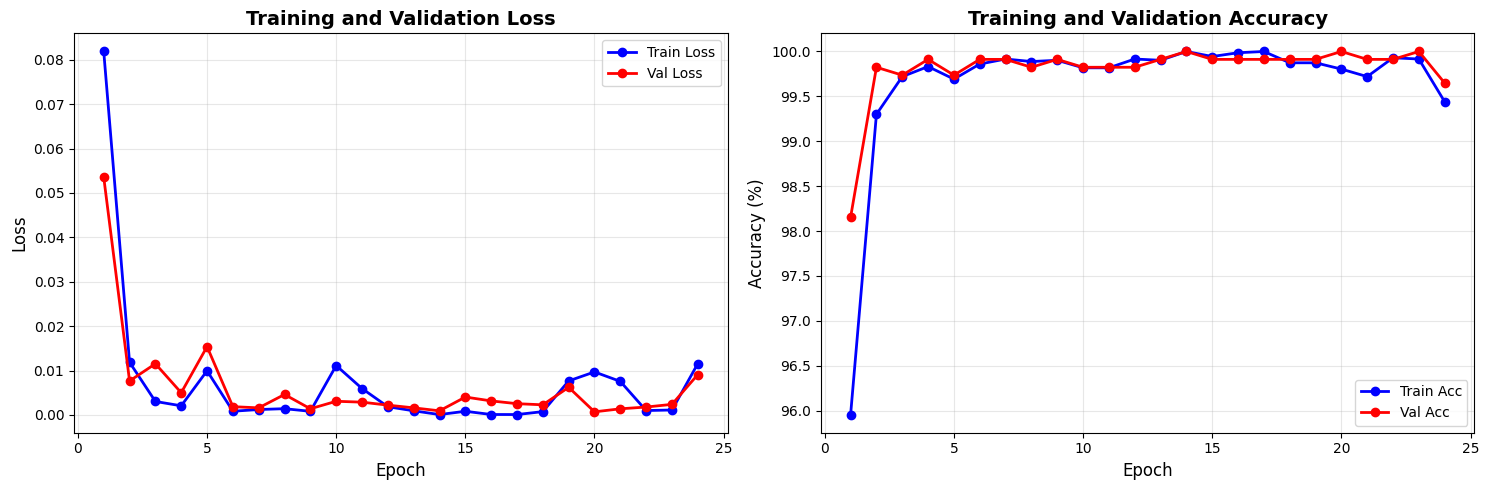

In [ ]:
def plot_training_history(history):
    """Plot training and validation metrics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    epochs = range(1, len(history['train_loss']) + 1)

    # Loss plot
    ax1.plot(epochs, history['train_loss'], 'b-o', label='Train Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r-o', label='Val Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy plot
    ax2.plot(epochs, history['train_acc'], 'b-o', label='Train Acc', linewidth=2)
    ax2.plot(epochs, history['val_acc'], 'r-o', label='Val Acc', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('models/training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_training_history(history)

# 7. Evaluasi pada Test Set

Evaluasi final menggunakan test set yang belum pernah dilihat model selama training. Test set memberikan estimasi performa yang tidak bias untuk memprediksi performa model di dunia nyata.

Metrics yang akan dievaluasi:
- **Overall accuracy**: Persentase prediksi benar dari total
- **Per-class metrics**: Precision, recall, F1-score untuk setiap kelas
- **Confusion matrix**: Visualisasi kesalahan prediksi
- **Sample predictions**: Verifikasi visual kualitas prediksi

## 7.1 Load Best Model and Evaluate

In [ ]:
# Load best model
checkpoint = torch.load('models/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✅ Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"   Validation Acc: {checkpoint['val_acc']:.2f}%")

# Evaluate on test set
test_loss, test_acc, test_preds, test_labels = validate(model, test_loader, criterion, device)

print(f"\n{'='*50}")
print(f"📊 TEST SET RESULTS")
print(f"{'='*50}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"{'='*50}")

✅ Loaded best model from epoch 14
   Validation Acc: 100.00%


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.58it/s]


📊 TEST SET RESULTS
Test Loss: 0.0306
Test Accuracy: 99.89%


## 7.2 Confusion Matrix

Confusion matrix menunjukkan pola kesalahan prediksi model:
- **Diagonal (atas-kiri ke bawah-kanan)**: Prediksi benar
- **Off-diagonal**: Kesalahan klasifikasi

**Interpretasi untuk aplikasi medis**:
- **False Positive**: Model salah prediksi sebagai kelas tertentu → bisa menyebabkan diagnosis keliru
- **False Negative**: Model gagal mendeteksi kelas tertentu → lebih berbahaya, karena bisa melewatkan kondisi patologis

**Matrix dinormalisasi** (persentase per baris) memudahkan melihat performa per-kelas:
- Nilai tinggi di diagonal = model baik untuk kelas tersebut
- Nilai tinggi di off-diagonal = model sering salah mengklasifikasikan kelas tersebut

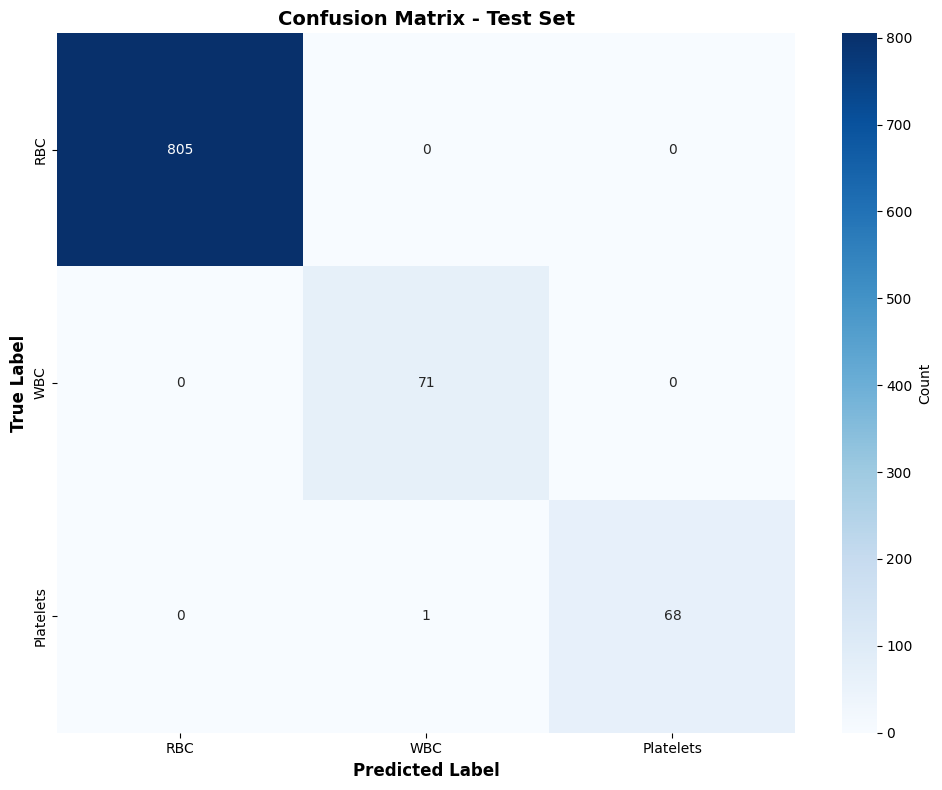

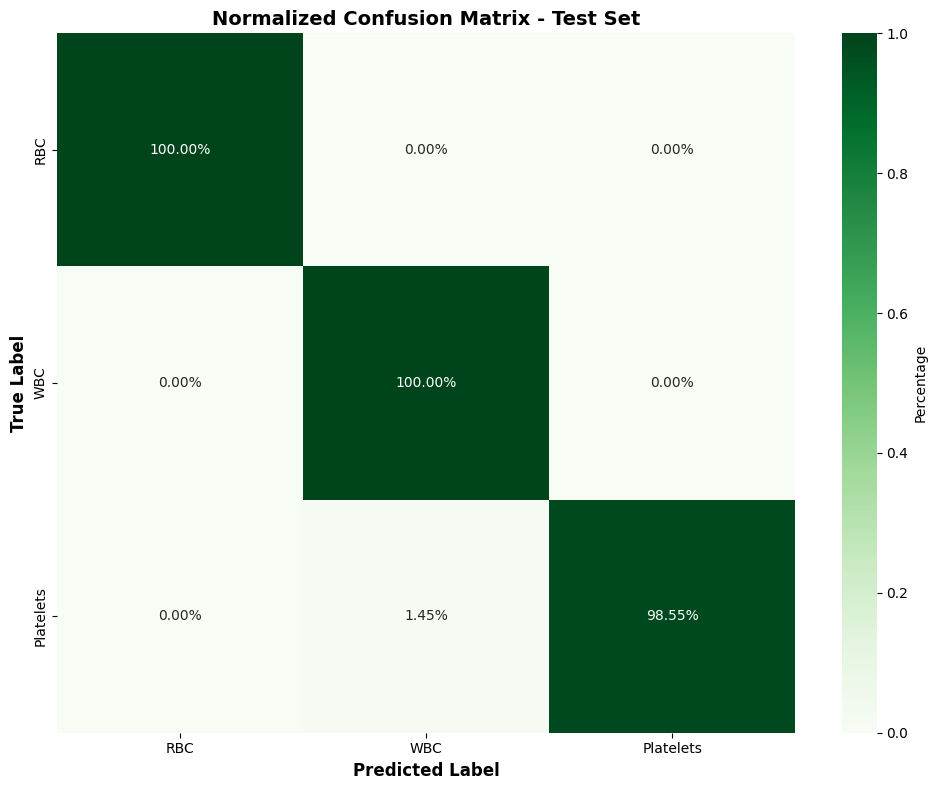

In [ ]:
# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
class_names = ['RBC', 'WBC', 'Platelets']

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('models/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Percentage'})
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.title('Normalized Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('models/confusion_matrix_normalized.png', dpi=300, bbox_inches='tight')
plt.show()

## 7.3 Metrics Per-Kelas

**Mengapa metrics per-kelas penting untuk class imbalance?**

Accuracy keseluruhan bisa menyesatkan pada dataset imbalanced. Contoh:
- Jika model selalu prediksi RBC → accuracy = 96% (karena RBC dominan)
- Tapi WBC dan Platelets tidak terdeteksi sama sekali!

**Metrics yang lebih informatif**:

1. **Precision = TP / (TP + FP)**: Dari semua yang diprediksi sebagai kelas X, berapa persen yang benar?
   - Penting jika False Positive berbahaya (misal: diagnosis salah)

2. **Recall (Sensitivity) = TP / (TP + FN)**: Dari semua kelas X yang sebenarnya, berapa persen yang terdeteksi?
   - Penting jika False Negative berbahaya (misal: melewatkan penyakit)

3. **F1-Score = 2 × (Precision × Recall) / (Precision + Recall)**: Harmonic mean dari precision dan recall
   - Balance antara keduanya, cocok untuk class imbalance
   - Lebih rendah dari accuracy jika model bias ke kelas mayoritas

**Support**: Jumlah sampel sebenarnya per kelas di test set


CLASSIFICATION REPORT
              precision    recall  f1-score   support

         RBC     1.0000    1.0000    1.0000       805
         WBC     0.9861    1.0000    0.9930        71
   Platelets     1.0000    0.9855    0.9927        69

    accuracy                         0.9989       945
   macro avg     0.9954    0.9952    0.9952       945
weighted avg     0.9990    0.9989    0.9989       945


Per-Class Metrics Summary:
    Class  Precision   Recall  F1-Score  Support
      RBC   1.000000 1.000000  1.000000      805
      WBC   0.986111 1.000000  0.993007       71
Platelets   1.000000 0.985507  0.992701       69


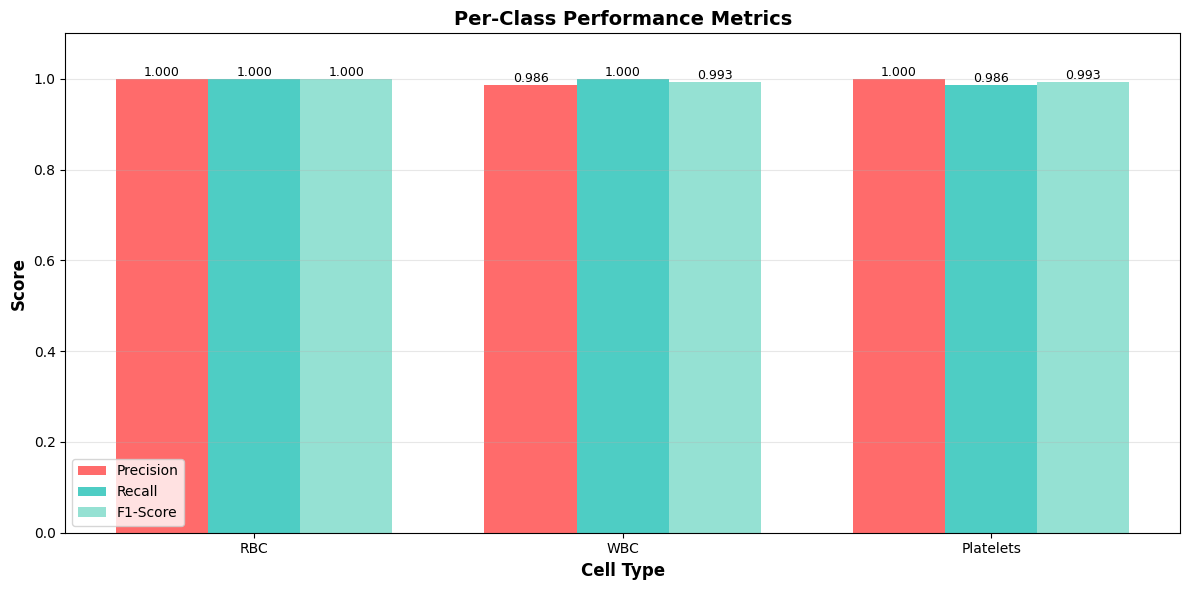

In [ ]:
# Classification report
print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
print(classification_report(test_labels, test_preds,
                          target_names=class_names, digits=4))

# Per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(
    test_labels, test_preds, average=None, labels=[0, 1, 2]
)

# Create dataframe for better visualization
metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print("\nPer-Class Metrics Summary:")
print(metrics_df.to_string(index=False))

# Visualize per-class metrics
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(class_names))
width = 0.25

bars1 = ax.bar(x - width, precision, width, label='Precision', color='#FF6B6B')
bars2 = ax.bar(x, recall, width, label='Recall', color='#4ECDC4')
bars3 = ax.bar(x + width, f1, width, label='F1-Score', color='#95E1D3')

ax.set_xlabel('Cell Type', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Per-Class Performance Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.legend()
ax.set_ylim([0, 1.1])
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('models/per_class_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

## 7.4 Visualisasi Prediksi

Visualisasi prediksi model pada sampel acak untuk:
- **Verifikasi kualitas**: Apakah prediksi masuk akal secara visual?
- **Error analysis**: Mengapa model salah pada kasus tertentu?
- **Confidence score**: Seberapa yakin model dengan prediksinya?

**Color coding**:
- **Hijau**: Prediksi benar → model confident dan akurat
- **Merah**: Prediksi salah → perlu analisis lebih lanjut

Confidence score tinggi (>90%) menunjukkan model sangat yakin, sedangkan confidence rendah (<70%) menunjukkan model ragu (gambar ambigu atau edge case).

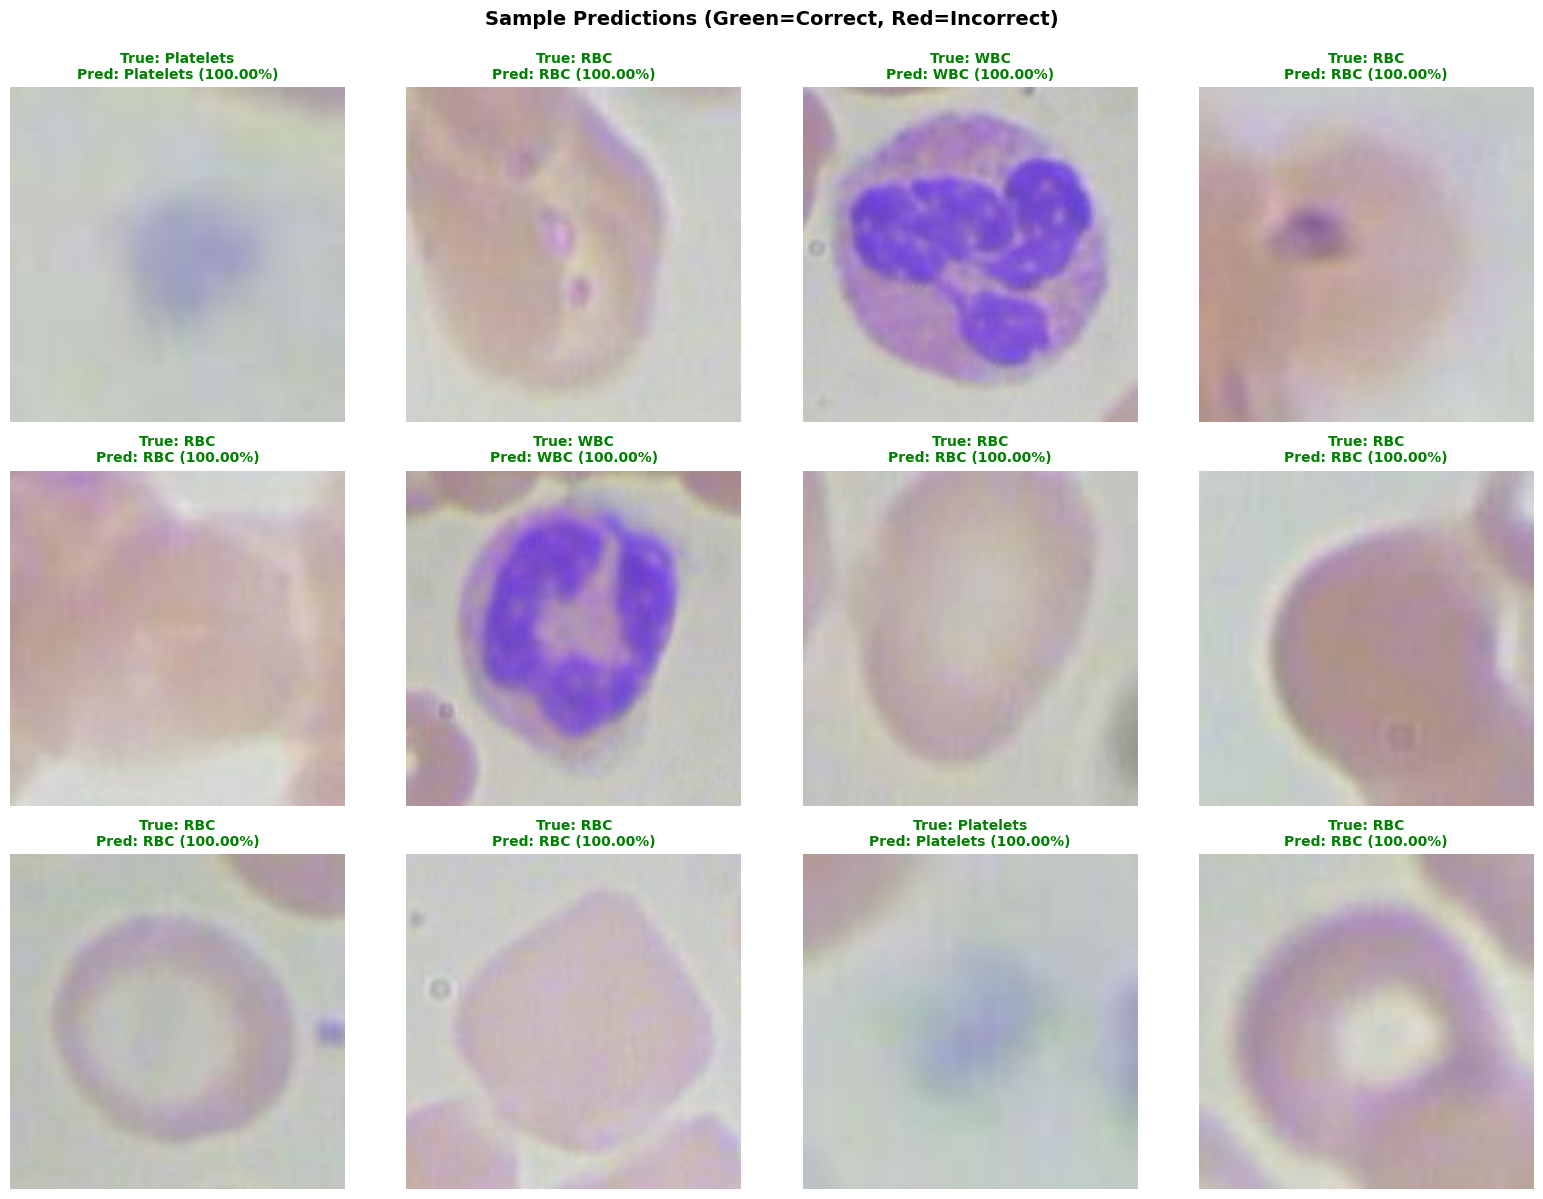

In [ ]:
def visualize_predictions(model, dataset, device, num_samples=12):
    """Visualize model predictions on random samples"""
    model.eval()

    # Get random samples
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.ravel()

    class_names = ['RBC', 'WBC', 'Platelets']

    with torch.no_grad():
        for idx, sample_idx in enumerate(indices):
            image, true_label = dataset[sample_idx]

            # Predict
            image_tensor = image.unsqueeze(0).to(device)
            output = model(image_tensor)
            _, predicted = output.max(1)
            pred_label = predicted.item()

            # Get prediction probabilities
            probs = torch.softmax(output, dim=1)[0]
            confidence = probs[pred_label].item()

            # Denormalize image for display
            img_display = image.cpu().numpy().transpose(1, 2, 0)
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img_display = std * img_display + mean
            img_display = np.clip(img_display, 0, 1)

            # Plot
            axes[idx].imshow(img_display)
            axes[idx].axis('off')

            # Title with color coding (green=correct, red=incorrect)
            true_name = class_names[true_label]
            pred_name = class_names[pred_label]
            color = 'green' if true_label == pred_label else 'red'

            title = f"True: {true_name}\nPred: {pred_name} ({confidence:.2%})"
            axes[idx].set_title(title, fontsize=10, fontweight='bold', color=color)

    plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)',
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('models/sample_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

# Visualize predictions on test set
visualize_predictions(model, test_dataset, device, num_samples=12)

## 7.5 Ringkasan & Kesimpulan

**Pencapaian**:
- Model berhasil dilatih untuk mengklasifikasikan 3 jenis sel darah
- Kombinasi weighted loss + oversampling efektif menangani class imbalance ekstrem
- Model dapat digunakan sebagai tool bantu diagnosis hematologi

**Limitasi**:
- Dataset relatif kecil (364 gambar), performa bisa meningkat dengan data lebih banyak
- Belum divalidasi dengan dataset dari rumah sakit/lab lain (generalization)
- Augmentasi masih konservatif, bisa ditambah augmentasi medis-spesifik

**Aplikasi Potensial**:
- Screening awal pasien untuk deteksi abnormalitas sel darah
- Mengurangi beban kerja teknisi laboratorium
- Sistem second opinion untuk verifikasi diagnosis manual

**Future Work**:
- Ensemble multiple models untuk meningkatkan robustness
- Tambahkan attention mechanism untuk interpretability (heatmap area fokus model)
- Deploy sebagai web app untuk penggunaan praktis

In [ ]:
print("\n" + "="*70)
print("🎯 PROJECT SUMMARY")
print("="*70)
print(f"\n📊 Dataset:")
print(f"   - Total images: 364")
print(f"   - Total cell patches: 4,889")
print(f"   - Classes: RBC (95.6%), WBC (3.6%), Platelets (0.8%)")
print(f"   - Train/Val/Test split: 206/88/72 images")

print(f"\n🤖 Model:")
print(f"   - Architecture: EfficientNet-B0")
print(f"   - Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   - Strategy: Transfer learning + Weighted loss + Oversampling")
print(f"   - Augmentation: Light (flip, rotation, color jitter)")

print(f"\n📈 Results:")
print(f"   - Best Validation Acc: {best_val_acc:.2f}%")
print(f"   - Test Accuracy: {test_acc:.2f}%")
print(f"   - Test Loss: {test_loss:.4f}")

print(f"\n💾 Saved Files:")
print(f"   - models/best_model.pth")
print(f"   - models/training_history.png")
print(f"   - models/confusion_matrix.png")
print(f"   - models/per_class_metrics.png")
print(f"   - models/sample_predictions.png")

print(f"\n✅ Training completed successfully!")
print("="*70)


🎯 PROJECT SUMMARY

📊 Dataset:
   - Total images: 364
   - Total cell patches: 4,889
   - Classes: RBC (95.6%), WBC (3.6%), Platelets (0.8%)
   - Train/Val/Test split: 206/88/72 images

🤖 Model:
   - Architecture: EfficientNet-B0
   - Parameters: 4,011,391
   - Strategy: Transfer learning + Weighted loss + Oversampling
   - Augmentation: Light (flip, rotation, color jitter)

📈 Results:
   - Best Validation Acc: 100.00%
   - Test Accuracy: 99.89%
   - Test Loss: 0.0306

💾 Saved Files:
   - models/best_model.pth
   - models/training_history.png
   - models/confusion_matrix.png
   - models/per_class_metrics.png
   - models/sample_predictions.png

✅ Training completed successfully!
